<a href="https://colab.research.google.com/github/mthomp24/InsuranceClaimPredictionSample01/blob/master/Copy_of_Mariana_Silva_GCA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

GCA 2 will require approximately four hours of your time.  You may complete GCA 2 in Colab or locally on your machines.  Please post any code you develop to GitHub.  Make sure that each of your group members has access to your group repository.

In GCA 2, you will code your own model to identify images of cats from other images.  Specifically, you will code a logistic regression classisier.  This assignment was inspired by Andrew Ng's Deep Learning course offered by deeplearning.ai, adapted from your instructor's own notes.  Your instructor assembled the data.  Images were taken from the Cats and Dogs dataset on Kaggle and Caltech 101 Image Dataset.

Let's get started.

## Step 1: Mount Google Drive and Download Images

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Download images from the following link:

https://drive.google.com/open?id=1pNbSKJNl4SUVguMpIfK7UI9CtyubbS9M

Place the file contaning the images (`images.h5`) in a convenient place in your Google Drive.

## Step 2: Import Modules

Import the modules `h5py`, `numpy`, and `matplotlib`.

In [0]:
import h5py
from matplotlib import pyplot as plt
import numpy as np

## Step 3:  Read Data File

Read the HDF5 file containing the images.  An HDF5 file is a smart data container.  For our purposes now, the file contains multi-dimensional arrays related to our images.

`Train/images`
<br>
Contains 4405 training images each with resolution 100 x 100.  It is a 4D NumPy array with shape `(num_images,100,100,3)`.  We read this data into the variable `images_train` below.

`Test/images`
<br>
Contains 1617 testing images each with resolution 100 x 100.  It is a 4D NumPy array with shape `(num_images,100,100,3)`.  We read this data into the variable `images_test` below.

`Train/labels`
<br>
A one-dimensional array with length equal to the number of training images.  It contains 1 or 0.  1 for cat.  0 for not cat.  The row in this array corresponds to the first index of `images_train`.  We read this data into the variable `labels_train` below.

`Test/labels`
<br>
A one-dimensional array with length equal to the number of testing images.  It contains 1 or 0.  1 for cat.  0 for not cat.  The row in this array corresponds to the first index of `images_test`.  We read this data into the variable `labels_test` below.

In [0]:
f = h5py.File('/content/drive/My Drive/images.h5', 'r')

images_train = f['Train/images'][...]
labels_train = f['Train/labels'][...]

images_test = f['Test/images'][...]
labels_test = f['Test/labels'][...]

f.close()

## Step 4: Plot Some Data

Let's get a better understanding of what these arrays contain.  Let's plot a cat and its correpsonding label.

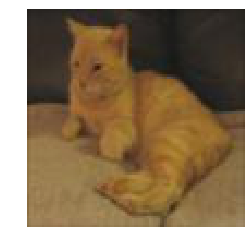

The label of this image is  1 .


In [0]:
image = images_train[3299]
label = labels_train[3299]

plt.axis('off')
plt.imshow(image)
plt.show()

print('The label of this image is ', label, '.')

Let's take a look of an image without a cat.

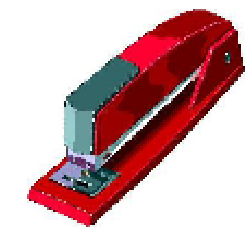

The label of this image is  0 .


In [0]:
image = images_train[3]
label = labels_train[3]

plt.axis('off')
plt.imshow(image)
plt.show()

print('The label of this image is ', label, '.')

Notice how the stapler has label 0.  This is because it is not a cat.  Only images with cats are labeled 1.  Also, notice that the images have been re-sized to have the same resolution.  This is necessary as our model will only accept RGB images of resolution 100 x 100.

What is `image`?  `image` is an image, but in Python, its simply a NumPy array.  It's a 100 x 100 x 3 NumPy array.  100 x 100 is the image resolution.  The `3` indicates that the image in encoded in RGB.  `[:,:,0]` is the red channel.  `[:,:,1]` is the green channel.  Finally, `[:,:,2]` is the blue channel.

Here is a better indication of the types of images in our dataset.

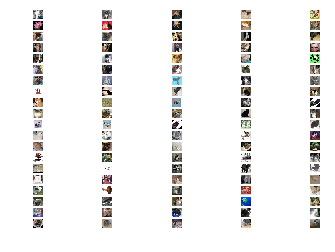

In [0]:
for i in range(500,600):
    plt.subplot(20, 5, i-499)
    plt.axis('off')
    plt.imshow(images_test[i])

plt.show()

## Step 5: Flatten the Images

For our model, we'll need to flatten our images.  Remember, each image is `100 x 100 x 3`.  We will preserve each pixel, but require a different pixel arrangement.  We convert each three-dimension NumPy image array to a one-dimension array using the method `flatten`.

In [0]:
num_train = images_train.shape[0]
images_train_flatten = images_train.flatten().reshape(num_train, 100*100*3)
print("Number Training Images: ", num_train)
print("Shape of Flattened Training Images Array: ", images_train_flatten.shape)

num_test = images_test.shape[0]
images_test_flatten = images_test.flatten().reshape(num_test, 100*100*3)
print("Number Testing Images: ", num_test)
print("Shape of Flattened Testing Images Array: ", images_test_flatten.shape)

Number Training Images:  4405
Shape of Flattened Training Images Array:  (4405, 30000)
Number Testing Images:  1617
Shape of Flattened Testing Images Array:  (1617, 30000)


## Step 6: Standardize the Data

Standardizing data is a very important step when creating machine leanring models.  What happens if our photos of cats were taken at different exposures?  We'd have to compensate for this, otherwise we'd might "train" our model to discriminate different exposures when classifying cats.  This is a waste and could compromise the accuracy of our model!  Instead, we normalize our images based on the highest permissible pixel value, 255.

In [0]:
train_set_x = images_train_flatten/255.
test_set_x = images_test_flatten/255.

## Step 7: Assembling the Model

The following image is from Andrew Ng's course on Deep Learning.  What are we looking at?  Basically, this is our predictor.  It accepts three imputs: a scalar bias, an array of weights with length equal to the total number of pixels in a given image (3x100x100), and flattened image(s).  You will learn how to train this predictor for improved identification.  Effectively, your goal is to settle on an optimized scalar bias and array of weights.

![alt text](https://github.com/andersy005/deep-learning-specialization-coursera/raw/8fd8ad74a9b2d8321bb0a701c5c0f3ec4abad144/01-Neural-Networks-and-Deep-Learning/week2/Programming-Assignments/images/LogReg_kiank.png)

Working from left to right, an image is flattened and normalized (we've already done this).  Each pixel is multiplied by its corresponding weight.  The products are summed.  The scalar bias is then added to this summation.  This result, in turn, is pushed through the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).  The sigmoid function is known as an activation function and outputs a scalar between 0 and 1.

![alt text](https://cdn-images-1.medium.com/max/1600/1*Xu7B5y9gp0iL5ooBj7LtWw.png)

Once our model is sufficiently trained, you can think of this scalar as a probability that the image contains a cat.  For example, if the "probability" is greater than 0.5, we classify the image as cat.

Let's start coding pieces of the model.

### Sigmoid Function

In [0]:
def sigmoid(z):
  
    """
    Computes the sigmoid function.
    
    input:  scalar or numpy array
    output: scalar or numpy array
    """

    s = 1. / ( 1 + np.exp(-z))
    
    return s

### Weights and Biases
To initialize the model, we need to zero-out our weight array and scalar bias.  Recall that each pixel is assigned its own weight.

In [0]:
def initialize_model(dim):
  
    """
    Returns initialized weight array and bias scalar.
    
    input:  number of weights
    output: weights (array), biases (scalar)
    """
    
    w = np.zeros(shape=(dim, 1), dtype=float)
    b = 0
    
    return w,b

## Step 8: Training the Model
Training the model consists of iteratively determining an optimized set of input parameters.  These parameters are the weights and scalar bias.

We first define forward propagation.  Forward propagation consists of exercising the weights and bias on all available training images, calculating an activation from the sigmoid function for each, and finally calculating a cost (or loss) associated with our "predictions".  We use the cross-entropy cost.  Please read [here](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#cost-function) for more details.  Regardless of number of images, cost will always be a scalar.  The higher the cost, the worse our predictions.

In [0]:
def forward_propagate(X, Y, w, b):
  
    """
    Returns array of activations (one per image)
    and cost (scalar).
    
    input:  X     array of flattened images (num_pixels,num_images)
            Y     array of labels, 1 or 0 (num_images)
            w     array of weights (num_pixels,1)
            b     scalar bias (float)
    output: A     array of activations (num_images)
            cost  loss (float)
    """
  
    # get number of images under consideration
    num_images = X.shape[1]
  
    # calculate the activation for each image
    A = sigmoid(np.dot(w.T, X) + b)
  
    # calculate the cost (scalar) using cross-entropy
    cost = np.squeeze( (-1. / num_images) * np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1) )
  
    return A, cost  

We propagate backwards to minimize our cost.  This involves taking derivatives of the cost function.  We take derivatives in terms of our weights and scalar bias.  For more info, read [here](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#gradient-descent).  Without this function, our optimization routine is aimless.

In [0]:
def backward_propagate(X, Y, A):
  
    """
    Returns a dictionary of derivatives of cost function.
    
    input:  X      array of flattened images (num_pixels,num_images)
            Y      array of labels, 1 or 0 (num_images)
            A      array of activations (num_images)
    output: grads  dictionary with keys dw and db
    """
    
    # get number of images under consideration
    num_images = X.shape[1]
  
    # derivative of cost function wrt w (scalar)
    dw = (1./num_images)*np.dot(X,((A-Y).T))
    
    # To find the derivatives of the cost functions we will first look at the sigmoid function and divise that to dz/dphi = phi(phi-1) and then considerr z = x.w and divise this to get dphi/dWi = (dz/dphi)(dw/dz) = phi(phi-1)Xi.
    # To get our new dw we will use the equation: Wnew = Wold - n(dphi/dWi). The Wold being the old dw and the n being the number of images that are being run through. This will allow us to take smaller sections of the gradient descent of the curve and decrese the error.
    
    
    # derivative of cost function wrt b (scalar)
    db = (1./num_images)*np.sum(A-Y,axis=1)
    
    #To find the derivative of the cost function db, it is very similar to that of dw. Though, the z changes for it is a sum of x and w and not a dot product. Thus, z = x + w and the db/dz = 2.
    #Though the dz/dphi will stay the same as that from dw. Thus dphi/dbi = (dz/dphi)(db/dz) = phi(phi-1)2. Then to get the final db we will get Bnew = Bold - n(dphi/dbi).
  
    # create dictionary of derivatives (gradients)
    grads = {"dw": dw, "db": db}
  
    return grads

We can now assemble our optimization routine.  This routine is known as gradient descent.  It is an iterative process.  For each iteration, we conduct forward and backward propagation.  We update our array of weights and scalar bias by subtracting gradients from their previous values.  We apply a learning rate to this update.  If the learning rate is too high, our optimization procedure will not converge.  If the learning rate is too low, our optimization routine will converge to a solution, albeit slowly.  

In [0]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    """
    Optimize array of weights and scalar bias.
    
    input:  w               array of weights (num_pixels,1)
            b               scalar bias (float)
            X               array of flattened images (num_pixels,num_images)
            Y               array of labels, 1 or 0 (num_images)
            num_iterations  number of iterations for optimization (scalar)
            learning_rate   gradient multiplier (scalar)
            print_cost      boolean controlling user feedback
    output: params          w and b after num_iterations of optimization
            grads           dictionary with keys dw and db
            costs           history of cost during optimization (list)
    """
    
    costs = []
    
    # iterate
    for i in range(num_iterations):
        
        # forward propagation
        A, cost = forward_propagate(X, Y, w, b)
        
        # backward propagation
        grads = backward_propagate(X, Y, A)
        dw = grads["dw"]
        db = grads["db"]
        
        # update array of weights and scalar bias
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # save the costs (every 100th)
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 10 training examples
        if print_cost:
          if i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    # save optimized w and b in dictionary
    params = {"w": w,
              "b": b}
    
    # save dw and db
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Let's now code a function to actually do our prediciton.  Remember, an activation >= 0.5 is a cat.  Else, it's not a cat.

In [0]:
def predict(w, b, X):
    '''
    Given a set of flattened images, predict their labels.
    
    input:   w               array of weights (num_pixels,1)
             b               scalar bias (float)
             X               array of flattened images (num_pixels,num_images)
    output:  Y_prediction    array of predictions (num_images)
    '''
    
    # get number of images
    num_images = X.shape[1]
    
    # initialize prediction array
    Y_prediction = np.zeros((1,num_images))
    
    # calculate activation (probability) for each image
    A = sigmoid(np.dot(w.T, X) + b)
    
    # make predictions
    Y_prediction[A>=0.5] = 1
    Y_prediction[A<0.5] = 0
    
    return Y_prediction

We now wrap everything up conveniently in a single function that orchestrates the optimization and reports diagnostics.

In [0]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    A wrapper for gradient descent.
    
    input:   X_train         array of flattened images for training (num_pixels,num_train)
             Y_train         array of training labels (num_train)
             X_test          array of flattened images for testing (num_pixels,num_test)
             Y_test          array of testing labels (num_test)
             num_iterations  number of iterations for optimization (scalar)
             learning_rate   gradient multiplier (scalar)
             print_cost      boolean controlling user feedback
    output:  d               a dictionary of parameters and costs
    """
    
    # initialize
    w, b = initialize_model(X_train.shape[0])
    
    # gradient descent with training set (optimization)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # get w and b
    w = parameters["w"]
    b = parameters["b"]
    
    # predict on testing and training set
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # print errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    # save some parameters into a dictionary
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
  
#  if __name__ == "__main__":
#    model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False)

IndentationError: ignored

Let's run everything.

In [0]:
d = model(train_set_x.T, labels_train, test_set_x.T, labels_test, num_iterations = 1000, learning_rate = 0.002, print_cost = True)



## Your Assignment
In cells below (or in a Python script), include the following:

*   Try to improve the prediction.  To do this, you can modify the training and testing sets (perhaps we need more non-cats in training).  You can try a different activation function.  You can obviously try different numbers of iterations.  Be creative.  Report everything you have tried.  For each attempt include code, output, and a discussion.
*   Derive the derivatives of the cost function, `dw` and `db`.
*  In a couple of paragraphs, summarize what you have learned.  Discuss limitations of the approach.  Image recognition is not done this way in production environments!  Discuss how it is done by data scientists today.  Google around.  Some of you will be using these methods for your FCC.


